<a href="https://colab.research.google.com/github/akashe/NLP/blob/main/assignment/English_to_German_Seq2Seq_Attn_with_seq_lengths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for English to German translation using Seq2Seq architecture with packed sequences, attention masking and BLEU scores. Note: the german translations are in reverse order

In [1]:
!pip install torchtext==0.5.0 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

import os, pickle

In [3]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [6]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [7]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True)

TRG = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), 
                                                    fields = (SRC, TRG))

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [10]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, sort_key=lambda x: len(x.src),sort_within_batch=True,
    device = device)

In [13]:
with open('source.pkl', 'wb') as src_tokens: 
  pickle.dump(SRC.vocab.stoi, src_tokens)
with open('target_stoi.pkl','wb') as trg_tokens:
  pickle.dump(TRG.vocab.stoi,trg_tokens)

with open('target_itos.pkl','wb') as trg_tokens:
  pickle.dump(TRG.vocab.itos,trg_tokens)

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src,src_len):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))        
        #embedded = [src len, batch size, emb dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,src_len.cpu())
        # packed_embedded: data_sequence[], batch_sequence[]

        packed_outputs, hidden = self.rnn(packed_embedded)

        outputs,_ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [39]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs,mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)

        #attention= [batch size, src len]

        attention = attention.masked_fill(mask==0,-1e10)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs,mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs,mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [41]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device,src_pad_idx):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.src_pad_idx = src_pad_idx

    def create_mask(self,src):
        mask = (src != self.src_pad_idx).permute(1,0)
        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src,src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)
        # mask: [batch_size,src_len]
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs,mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [42]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
src_pad_idx = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device,src_pad_idx).to(device)

In [43]:
def init_weights(m):
  for name,param in m.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param.data,mean=0,std=0.01)
    else:
      nn.init.constant_(param.data,0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(7855, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [44]:
pad_idx = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [45]:
optimizer = optim.Adam(model.parameters())

In [46]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total number of trainable params in the model = {}'.format(count_parameters(model)))

Total number of trainable params in the model = 24036783


In [47]:
from torchtext.data.metrics import bleu_score

def get_blue_score(translated,translation,itos_location="target_itos.pkl"):
  # translated : [trg_len,batch_size,output_dim]
  # translation : [trg_len,batch_size]

  # Load trg.itos
  trg_token_file = open(itos_location,'rb')
  trg_itos = pickle.load(trg_token_file)

  translated = torch.argmax(translated[1:],-1).T # translated : [batch_size,trg_len-1]
  translation = translation[1:].T # translation : [batch_size,trg_len-1]

  pred_ = []
  trg_ = []
  for i,j in zip(translated,translation):
    pred_.append([trg_itos[k.item()] for k in i if trg_itos[k.item()] not in ('<eos>','<pad>')]) # trim pad and eos tokens
    trg_.append([[trg_itos[k.item()] for k in j if trg_itos[k.item()] not in ('<eos>','<pad>')]])

  try:
    score = bleu_score(pred_,trg_)
    return score
  except IndexError:
    # My guess is that while doing split with split(" "), we are getting ngram len greater than 4
    # Find blue_score for each translated and translation sepearately
    
    # for i,j in zip(translated,translation):
    #   try:
    #     bleu_score([[trg_itos[k.item()] for k in i]],[[[trg_itos[k.item()] for k in j]]])
    #   except IndexError:
    #     print(f' Translated result {[trg_itos[k.item()] for k in i]}')
    #     print(f' Target Result {[trg_itos[k.item()] for k in j]}')

    '''
    The speculation was right. When the translated sentence has a ' ' in it. Then the length of ngram increases to 5 after splitting it string.split(" ")
    For now simply passing 0 score if this error is encountered.
    '''
    return 0

In [48]:
def train(model,iterator,optimizer,criterion,clip):
  model.train()

  epoch_loss = 0
  bleu_score = 0
  for i,batch in enumerate(iterator):

    src,src_len = batch.src
    trg = batch.trg

    optimizer.zero_grad()

    outputs = model(src,src_len,trg)

    #outputs : [trg_len,batch,output_dim]
    # trg :[trg_len,batch]

    output_dim = outputs.shape[-1]

    batch_bleu_score = get_blue_score(outputs,trg)
    bleu_score += batch_bleu_score

    outputs = outputs[1:].view(-1,output_dim)
    trg = trg[1:].view(-1)

    loss = criterion(outputs,trg)

    loss.backward()

    torch.nn.utils.clip_grad_norm(model.parameters(),clip)

    optimizer.step()

    epoch_loss += loss.item()
  
  return epoch_loss/len(iterator) , bleu_score/len(iterator)

In [52]:
def evaluate(model,criterion,iterator):
  model.eval()

  epoch_loss = 0
  bleu_score = 0
  for i,batch in enumerate(iterator):

    src,src_len = batch.src
    trg = batch.trg

    outputs = model(src,src_len,trg)

    output_dim = outputs.shape[-1]

    batch_bleu_score = get_blue_score(outputs,trg)
    bleu_score += batch_bleu_score

    outputs = outputs[1:].view(-1,output_dim)
    trg = trg[1:].view(-1)

    loss = criterion(outputs,trg)

    epoch_loss += loss.item()

  return epoch_loss/len(iterator) ,bleu_score/len(iterator)

In [53]:
def epoch_time(start_time,end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - elapsed_mins*60)
  return elapsed_mins, elapsed_secs

In [54]:
import torch.nn.functional as F
epochs = 20
clip = 1.

best_valid_loss = float('inf')

for epoch in range(epochs):

  start_time = time.time()

  train_loss,train_bleu = train(model,train_iterator,optimizer,criterion,clip)
  val_loss,val_bleu = evaluate(model,criterion,valid_iterator)

  end_time = time.time()

  if best_valid_loss > val_loss:
    best_valid_loss = val_loss
    torch.save(model.state_dict(),'english-german-seq2seq.pt')
  
  epoch_mins,epoch_secs = epoch_time(start_time,end_time)

  print(f'Epoch : {epoch+1:02} | Time: {epoch_mins:.3f} minutes ,{epoch_secs} seconds')
  print(f'\t Train Loss : {train_loss:.3f} | Train BLEU : {train_bleu:.4f} | Train PPL: {math.exp(train_loss):7.3f} ')
  print(f'\t Val loss : {val_loss:.3f} | Val BLEU: {val_bleu:.4f} |Val PPL: {math.exp(val_loss):7.3f}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch : 01 | Time: 1.000 minutes ,41 seconds
	 Train Loss : 4.073 | Train BLEU : 0.0400 | Train PPL:  58.714 
	 Val loss : 3.616 | Val BLEU: 0.0830 |Val PPL:  37.176
Epoch : 02 | Time: 1.000 minutes ,45 seconds
	 Train Loss : 3.401 | Train BLEU : 0.0954 | Train PPL:  29.989 
	 Val loss : 3.164 | Val BLEU: 0.1371 |Val PPL:  23.666
Epoch : 03 | Time: 1.000 minutes ,48 seconds
	 Train Loss : 2.903 | Train BLEU : 0.1394 | Train PPL:  18.234 
	 Val loss : 2.868 | Val BLEU: 0.1648 |Val PPL:  17.601
Epoch : 04 | Time: 1.000 minutes ,46 seconds
	 Train Loss : 2.508 | Train BLEU : 0.1768 | Train PPL:  12.276 
	 Val loss : 2.542 | Val BLEU: 0.1729 |Val PPL:  12.703
Epoch : 05 | Time: 1.000 minutes ,48 seconds
	 Train Loss : 2.189 | Train BLEU : 0.2149 | Train PPL:   8.923 
	 Val loss : 2.541 | Val BLEU: 0.2061 |Val PPL:  12.698
Epoch : 06 | Time: 1.000 minutes ,49 seconds
	 Train Loss : 1.886 | Train BLEU : 0.2636 | Train PPL:   6.590 
	 Val loss : 2.565 | Val BLEU: 0.2174 |Val PPL:  12.995
Epoc

In [59]:
# Testing the model
import spacy
nlp = spacy.load('en')

best_model_at = 'english-german-seq2seq.pt'
model.load_state_dict(torch.load(best_model_at))
model.eval()

# src stoi vocab
src_token_file = open("source.pkl",'rb')
src_vocab = pickle.load(src_token_file)


# target stoi vocab
trg_tokens_file = open('target_stoi.pkl','rb')
trg_stoi = pickle.load(trg_tokens_file)

# target itos vocab
trg_token_file = open("target_itos.pkl",'rb')
trg_itos = pickle.load(trg_token_file)


# Creating src tensor
custom_src_ = "A boy was swimming in the river."
tokenized_custom_src = [i.text.lower() for i in nlp.tokenizer(custom_src_)]
print(tokenized_custom_src)
tokenized_custom_src = ['<sos>'] + tokenized_custom_src +['<eos>']
custom_src = [src_vocab[i] for i in tokenized_custom_src]
custom_src = torch.LongTensor(custom_src).to(device).unsqueeze(1)
custom_src_len = torch.LongTensor([len(custom_src)]).to(device)

# Creating trg tensor
eval_trg_len = 15
trg_seq = [trg_stoi['<sos>']]
# There are two option to proceed. Pass src and trg to model.forward() or step by step model.encoder() and model.decoder(). With the second
# you can visualize attention

with torch.no_grad():
  encoder_outputs, hidden = model.encoder(custom_src,custom_src_len)

mask = model.create_mask(custom_src)

attentions = []
outputs = []

for i in range(eval_trg_len): # Could have used range(eval_trg_len)
  with torch.no_grad():
    trg_tensor = torch.LongTensor([trg_seq[-1]]).to(device)
    output, hidden,attention = model.decoder(trg_tensor,hidden,encoder_outputs,mask)
  attentions.append(attention)
  pred_token = output.argmax(1).item()
  trg_seq.append(pred_token)

  if pred_token == trg_stoi['<eos>']:
    break

attentions = torch.cat(attentions).to(device)
translation = [trg_itos[i] for i in trg_seq]
translation_joined = " ".join(trg_itos[i] for i in trg_seq[1:-1][::-1])
print(f" German translation : {translation_joined}")

['a', 'boy', 'was', 'swimming', 'in', 'the', 'river', '.']
 German translation : ein junge , der in im fluss schwimmt .


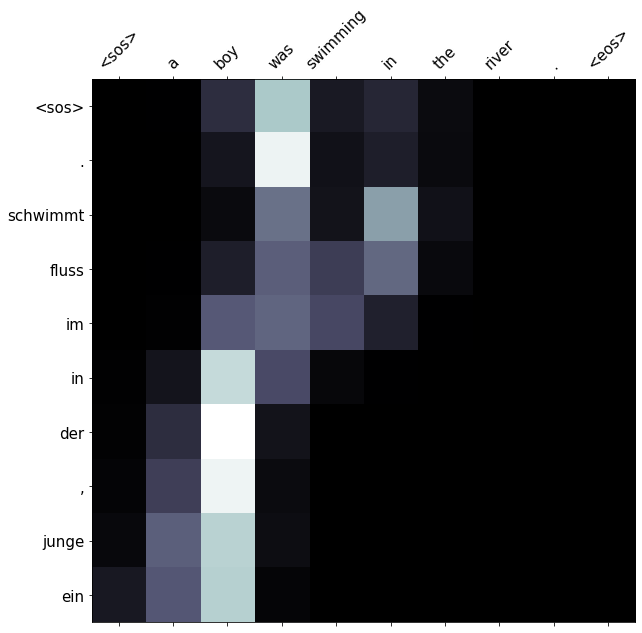

In [60]:
# Printing Attention vector
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
def display_attention(sentence,translation,attention):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111)

  attention = attention.squeeze(1).cpu().detach().numpy()

  cax = ax.matshow(attention, cmap='bone')

  ax.tick_params(labelsize=15)
  ax.set_xticklabels(['']+[t for t in tokenized_custom_src],rotation=45)
  ax.set_yticklabels(['']+ [t for t in translation])

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  plt.close()

display_attention(custom_src_,translation,attentions)